# VIC Clustering Validation Results Analysis

This notebook presents the obtained results of VIC Clustering Validation on 50 different partitions of our QS Top 200 2019 Scientometrics data set. We present different visualazations of the results and to keep the report didactic, some explanation of the code is included

Load necessary libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import pandas as pd

import os
import json

Load json report generated with `vic.py` into a python dict

In [2]:
with open('./report.json','r') as fp:
    report_dict = json.load(fp)

Separate metrics into lists for easier handling

In [3]:
all_partitions = list(report_dict.keys())
all_vs = []
all_scores = []
all_best_c = []

for key in all_partitions:
    all_vs.append(report_dict[key]['v'])
    all_scores.append(report_dict[key]['scores'])
    all_best_c.append(report_dict[key]['best_classifier'])

## And the Best Partition according to VIC is...

Let's find the partition with the highest VIC score.

In [4]:
idx = np.argmax(all_vs)
print('Best Partition:\n\t{}\n\tv = {}\n\tClassifier: {}'.format(all_partitions[idx],all_vs[idx],all_best_c[idx]))

Best Partition:
	QS_Split081
	v = 0.8112201687201688
	Classifier: random_forest


## Overall VIC Score

The following figure shows the VIC score for 50 different partitions of the data set. 

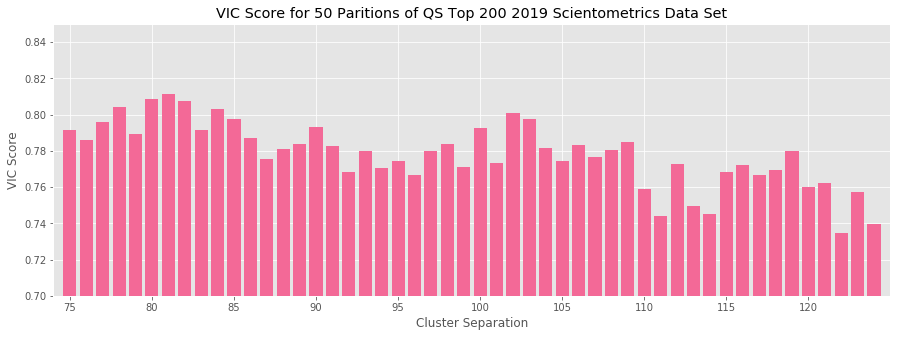

In [5]:
fig,ax = plt.subplots(1,1,figsize = (15,5))
ax.bar(np.arange(50),np.array(all_vs),color='#F36997')
ax.set_title('VIC Score for 50 Paritions of QS Top 200 2019 Scientometrics Data Set')
fig = ax.set(ylim = [0.7,0.85],xlim=(-1,50))
fig = ax.set_xlabel('Cluster Separation')
fig = ax.set_ylabel('VIC Score')
fig = ax.set_xticks(np.arange(0,50,5))
fig = ax.set_xticklabels(np.arange(75,124,5))
plt.savefig('./vic.png')

Going from rank 74 to 124, each partition is generated by placing all Universities below the rank in cluster 0 and its complement is placed in cluster 1. Afterwards, each classifier was used to train a model where the labels are the assigned clusters. 10-Fold Cross Validation was used and the average AUC is reported for each classifier and partition. For each partition we keep only the highest AUC score and report it as the VIC score.

## Individual Classifiers

Let us now look at the performance for each classifier in the process.

Separate into lists fo easier handling

In [6]:
all_rf = [f[0] for f in all_scores]
all_svm = [f[1] for f in all_scores]
all_nb = [f[2] for f in all_scores]
all_lda = [f[3] for f in all_scores]
all_gb = [f[4] for f in all_scores]
all_lr = [f[5] for f in all_scores]

all_2 = [all_rf,all_svm,all_nb,all_lda,all_gb,all_lr]

Setup names and colors for visualizations

In [7]:
classifiers = ['Random Forest','SVM','Naive Bayes','LDA','Gradient Boosting','Logistic Regression']
colors = ['#4FC7FB','#3259CE','#FF7260','#FEB8A8','#FDB7FC','#9474DB']

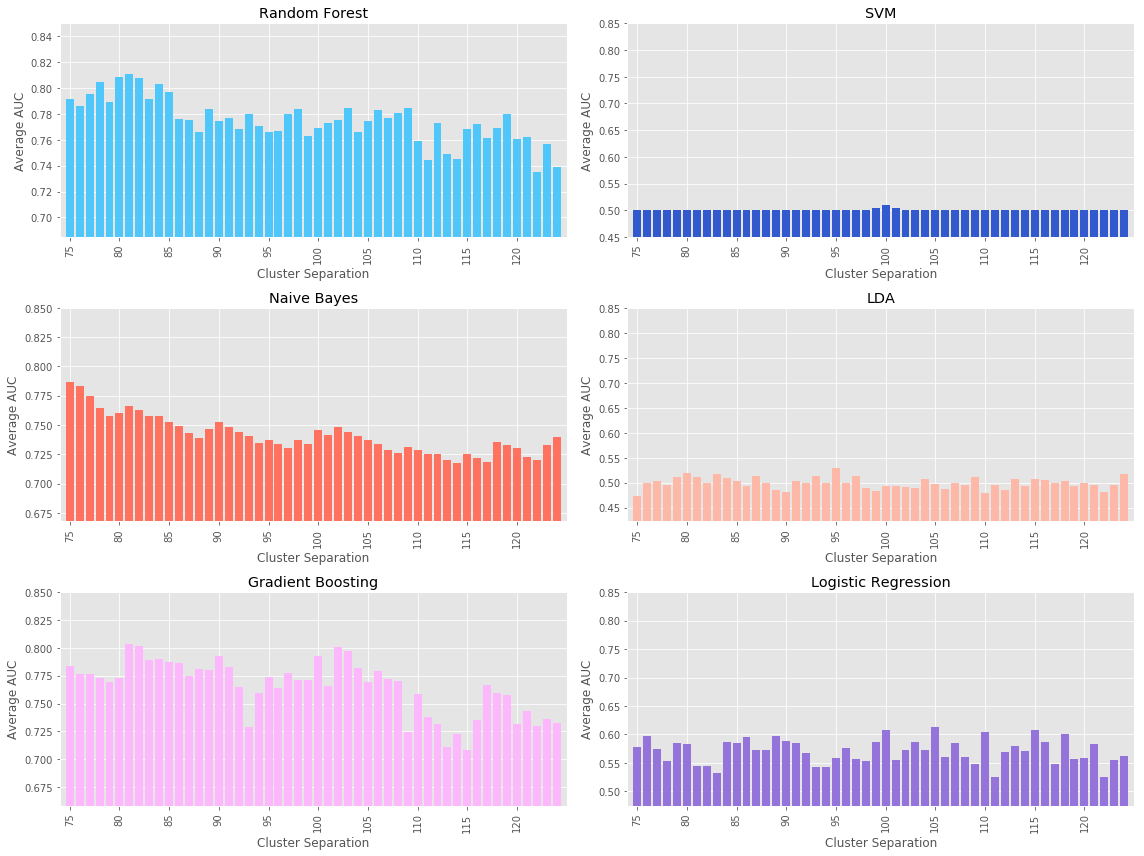

In [8]:
fig,ax = plt.subplots(3,2,figsize = (16,12))

for i,scores in enumerate(all_2):
    row    = (int)(i / 2)
    col = i % 2
    
    ax[row,col].bar(np.arange(50),np.array(scores),color=colors[i])
    
    this_min = min(scores)
    
    ax[row,col].set_title(classifiers[i])
    fig = ax[row,col].set(ylim = [this_min-0.05,0.85],xlim=(-1,50))
    fig = ax[row,col].set_xlabel('Cluster Separation')
    fig = ax[row,col].set_ylabel('Average AUC')
    fig = ax[row,col].set_xticks(np.arange(0,50,5))
    fig = ax[row,col].set_xticklabels(all_partitions[::5],rotation = 90)
    fig = ax[row,col].set_xticklabels(np.arange(75,124,5))
plt.tight_layout()
plt.savefig('./all_classifiers.png')

Now we have a better idea of how each VIC score was generated. Generally it seems like Random Forests were the highest scoring models but Gradient Boosting seems to be obtaining good results now and then. The SVM and LDA are the worst performing models.

## MVP
 Let's look at the number of highest scores obtained by each classifier.

In [9]:
classifiers2 = ['random_forest','svm','naive_bayes','lda','gradient_boosting','logistic_regression']

In [10]:
classif_freq = np.zeros((6,))

for i, classifier in enumerate(classifiers2):
    classif_freq[i] = all_best_c.count(classifier)

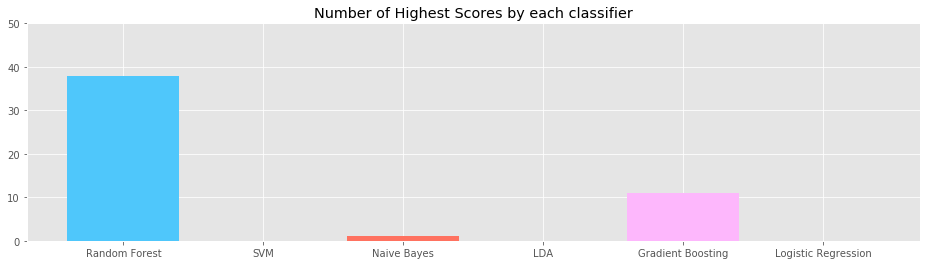

In [11]:
fig, ax = plt.subplots(1,1,figsize = (16,4))
ax.bar(np.arange(len(classif_freq)),classif_freq, color = ['#4FC7FB','#3259CE','#FF7260','#FEB8A8','#FDB7FC','#9474DB'])
ax.set_title('Number of Highest Scores by each classifier')
ax.set_xticks(np.arange(6))
ax.set_xticklabels(classifiers)
ax.set(ylim = [0,50])
plt.savefig('./MVP.png')

This is where most improvements could be made by selecting classifiers that are better suited to the task at hand. Out of the 6 classifiers, only thre ever achieved highest scores and one of them dominated by a very wide margin.

## Other Cluster Validation Techniques

Let us now compare the obtained results with some other Cluster Validation techniqued. We have chosen the Calinski Harabaz Score, the Silhouette Score and the Davies Bouldin Score.

In [12]:
from sklearn.metrics import calinski_harabaz_score, silhouette_score, davies_bouldin_score

In [13]:
cluster_files = [f for f in os.listdir('./QS_Partitions_CSV/') if f.endswith('.csv')]
cluster_files.sort()

In [14]:
all_scores_ch = []
all_scores_sil = []
all_scores_db = []


for cluster_file in cluster_files:
    df = pd.read_csv(os.path.join('./QS_Partitions_CSV/',cluster_file))
    df = df.drop([df.columns[0],df.columns[1]],axis = 1)

    values = df.values
    y = values[:,-1]
    x = values[:,:-1]
    
    this_score_ch = calinski_harabaz_score(x,y)
    this_score_sil = silhouette_score(x,y)
    this_score_db = davies_bouldin_score(x,y)
    
    all_scores_ch.append(this_score_ch)
    all_scores_sil.append(this_score_sil)
    all_scores_db.append(this_score_db)

/home/edoardobucheli/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/home/edoardobucheli/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/home/edoardobucheli/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/home/edoardobucheli/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/home/edoardobucheli/anaconda3/e

/home/edoardobucheli/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/home/edoardobucheli/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/home/edoardobucheli/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/home/edoardobucheli/anaconda3/envs/tf-gpu/lib/python3.6/site-packages/sklearn/metrics/cluster/unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances
/home/edoardobucheli/anaconda3/e

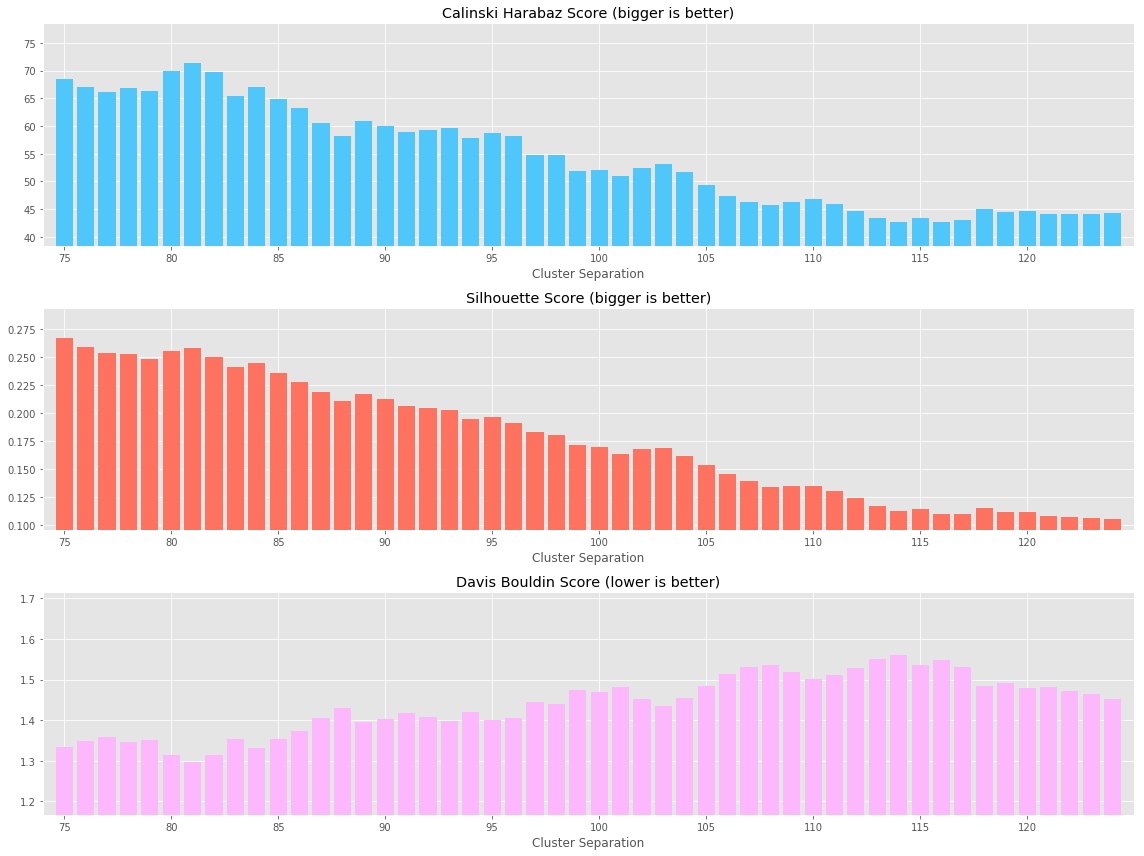

In [15]:
fig, ax = plt.subplots(3,1,figsize = (16,12))

scores = [all_scores_ch,all_scores_sil,all_scores_db]
names = ['Calinski Harabaz Score (bigger is better)','Silhouette Score (bigger is better)','Davis Bouldin Score (lower is better)']
colors = ['#4FC7FB','#FF7260','#FDB7FC']

for i,this_ax in enumerate(ax):
    
    this_ax.bar(np.arange(50),scores[i], color = colors[i])
    this_min = min(scores[i])
    this_max = max(scores[i])
    this_ax.set_xlabel('Cluster Separation')
    this_ax.set(ylim = [this_min-this_min*.1,this_max+this_max*0.1],xlim = [-1,50])
    this_ax.set_xticks(np.arange(0,50,5))
    this_ax.set_xticklabels(np.arange(75,125,5))
    this_ax.set_title(names[i])
plt.tight_layout()
plt.savefig('./OtherMetrics.png')

The Score for Calinski Harabaz and Davies Bouldin would both choose rank 81, same as VIC. This is not true for the Silhouette Score but rank 81 is still the 3rd best ranked partition.